# Import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, gridworld_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (gridworld_size[0] + end_point[0],
                                                                 gridworld_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = gridworld_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

# Dynamic Programming

## 01 PolicyIteration

In [ ]:
class PolicyIteration:
    def __init__(self, env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right']
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        # 상하좌우 동일한 확률로 초기화
        self.policy_table = np.full(shape=(env.height, env.width, self.num_action),
                                    fill_value=0.25).tolist()

        # end state's policy table should be empty
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # discount factor

    def policy_evaluation(self):
        # value fuction update
        for state in self.env.total_states:
            # 벨만 기대 방정식을 이용해 현재 정책에 대한 각 state의 가치를 구하기
            value = 0.0

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0

            else:
                state_policy = self.get_policy(state)

                for action_idx in range(self.num_action):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value += state_policy[action_idx] * (reward + self.gamma*next_value)

                self.value_table[state[0]][state[1]] = value

    def policy_improvment(self):
        next_policy = self.policy_table

        for state in self.env.total_states:

            value_list = []

            # 반환할 정책 초기화
            result = np.zeros(shape=(self.num_action)).tolist()

            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)

                value = reward + self.gamma * next_value
                value_list.append(value)

            # 받을 보상이 최대인 행동들에 대한 탐욕 정책 발전
            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0]

            # 최댓값이 여러 개일 때 확률을 나누기 위해
            prob = 1 / len(max_indices)

            for max_idx in max_indices:
                result[max_idx] = prob

            next_policy[state[0]][state[1]] = result

        self.policy_table = next_policy

    def get_policy(self, state):
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    def get_action(self,state):
        policy = self.get_policy(state)
        action = np.random.choice(range(len(self.action_space)), p=policy)
        return action

## main_PI

In [ ]:
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))

pi = PolicyIteration(env)

ITERATIONS = 15
RENDER_END = True
total_moves = []

In [ ]:
for iter in range(ITERATIONS):
    move_cnt = 0
    env.traces = [] # traces 초기화
    state = env.start_point

    pi.policy_evaluation()
    pi.policy_improvment()

    while state != env.end_point:
        action_idx = pi.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state

        env.traces.append(state)
        move_cnt += 1

    total_moves.append(move_cnt)

    print(f"ITERATION: {iter+1} / {ITERATIONS} __ move_cnt : {move_cnt}")

    if RENDER_END:
        env.render()

episode: 1 / 15 __ move_cnt : 19
S X X X X 
. X X X X 
. . . . X 
. . . . X 
. . . . A 

episode: 2 / 15 __ move_cnt : 20
S X . X . 
X X X X . 
. . . X . 
. . . X X 
. . . . A 

episode: 3 / 15 __ move_cnt : 10
S X X . . 
. . X X . 
. . . X . 
. . . X X 
. . . . A 

episode: 4 / 15 __ move_cnt : 13
S . . . . 
X X . . . 
X X . . . 
. X . . . 
. X X X A 

episode: 5 / 15 __ move_cnt : 25
S X . . . 
X X . . . 
. X . . . 
. X . . . 
. X X X A 

episode: 6 / 15 __ move_cnt : 8
S X X . . 
. . X . . 
. . X . . 
. . X X . 
. . . X A 

episode: 7 / 15 __ move_cnt : 8
S . . . . 
X X X X . 
. . . X . 
. . . X X 
. . . . A 

episode: 8 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X X X X 
. . . . X 
. . . . A 

episode: 9 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X . . . 
. X X . . 
. . X X A 

episode: 10 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X . . . . 
X . . . . 
X X X X A 

episode: 11 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X X X X 
. . . . X 
. . . . A 

episode: 12 / 15 __ move_

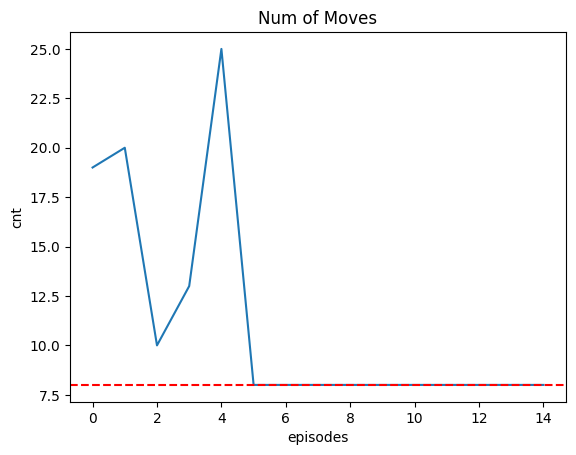

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--')
plt.ylabel("cnt")
plt.xlabel("ITERATIONS")
plt.title("Num of Moves")
plt.show()

In [ ]:
# 정책 테이블 표현하기

policy_table_df = pd.DataFrame()

for x in range(env.width):
    for y in range(env.height):
        policy_table_df[f"({x},{y})"] = pi.policy_table[x][y]

policy_table_df = policy_table_df.T
col_names = dict(zip(range(len(env.action_space)), env.action_space))
policy_table_df.rename(columns=col_names, inplace=True)
policy_table_df

,up,down,left,right
"(0,0)",0.0,0.5,0.0,0.5
"(0,1)",0.0,0.5,0.0,0.5
"(0,2)",0.0,0.5,0.0,0.5
"(0,3)",0.0,0.5,0.0,0.5
"(0,4)",0.0,1.0,0.0,0.0
"(1,0)",0.0,0.5,0.0,0.5
"(1,1)",0.0,0.5,0.0,0.5
"(1,2)",0.0,0.5,0.0,0.5
"(1,3)",0.0,0.5,0.0,0.5
"(1,4)",0.0,1.0,0.0,0.0


왜 0인가.

## 02 ValueIteration

In [ ]:
class ValueIteration:
    def __init__(self, env):
        # about env
        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # discount factor

    def value_iteration(self):
        for state in self.env.total_states:

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0

            else:
                value_list = []
                # 벨만 최적 방정식
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value = reward + self.gamma * next_value
                    value_list.append(value)

                # 최댓값을 다음 가치함수로 대입
                self.value_table[state[0]][state[1]] = max(value_list)

    def get_action(self, state):
        if state == self.env.end_point:
            return []

        else:
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0]
            action_idx = np.random.choice(max_indices)
            # return max_indices
            return action_idx

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]


## main_VI

In [ ]:
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))

vi = ValueIteration(env)

ITERATIONS = 15
RENDER_END = True
total_moves = []

In [ ]:
for iter in range(ITERATIONS):
    move_cnt = 0
    env.traces = [] # traces 초기화
    state = env.start_point

    vi.value_iteration()

    while state != env.end_point:
        action_idx = vi.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state

        env.traces.append(state)
        move_cnt += 1

    total_moves.append(move_cnt)

    print(f"ITERATIONS: {iter+1} / {ITERATIONS} __ move_cnt : {move_cnt}")

    if RENDER_END:
        env.render()

episode: 1 / 15 __ move_cnt : 25
S . X X X 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

episode: 2 / 15 __ move_cnt : 14
S X X X . 
. X X X X 
. . . . X 
. . . . X 
. . . . A 

episode: 3 / 15 __ move_cnt : 10
S X X . . 
. . X X . 
. . . X X 
. . . . X 
. . . . A 

episode: 4 / 15 __ move_cnt : 18
S X . . . 
X X . . . 
X X X X . 
. . . X X 
. . . . A 

episode: 5 / 15 __ move_cnt : 9
S . . . . 
X X . . . 
. X X X X 
. . . . X 
. . . . A 

episode: 6 / 15 __ move_cnt : 8
S X X . . 
. . X . . 
. . X . . 
. . X X X 
. . . . A 

episode: 7 / 15 __ move_cnt : 8
S X . . . 
. X X . . 
. . X X . 
. . . X . 
. . . X A 

episode: 8 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X X X X X 
. . . . X 
. . . . A 

episode: 9 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X . . . 
. X . . . 
. X X X A 

episode: 10 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X X . . . 
. X X . . 
. . X X A 

episode: 11 / 15 __ move_cnt : 8
S X X . . 
. . X X X 
. . . . X 
. . . . X 
. . . . A 

episode: 12 / 15 __ move_c

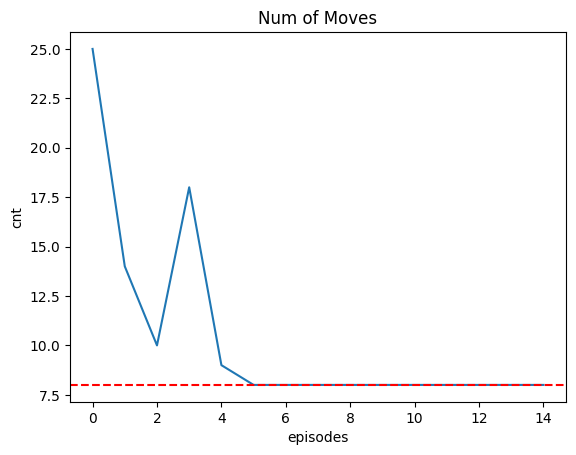

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--')
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [ ]:
# 가치 테이블
np.array(vi.value_table).round(3)

array([[0.478, 0.531, 0.59 , 0.656, 0.729],
       [0.531, 0.59 , 0.656, 0.729, 0.81 ],
       [0.59 , 0.656, 0.729, 0.81 , 0.9  ],
       [0.656, 0.729, 0.81 , 0.9  , 1.   ],
       [0.729, 0.81 , 0.9  , 1.   , 0.   ]])